In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Размер изображения: (1280, 920)
Форма numpy-массива: (920, 1280, 3)


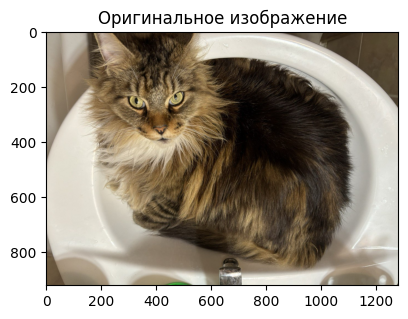

In [3]:
image = Image.open('photo.jpg')

image_array = np.array(image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image)

print("Размер изображения:", image.size)
print("Форма numpy-массива:", image_array.shape)

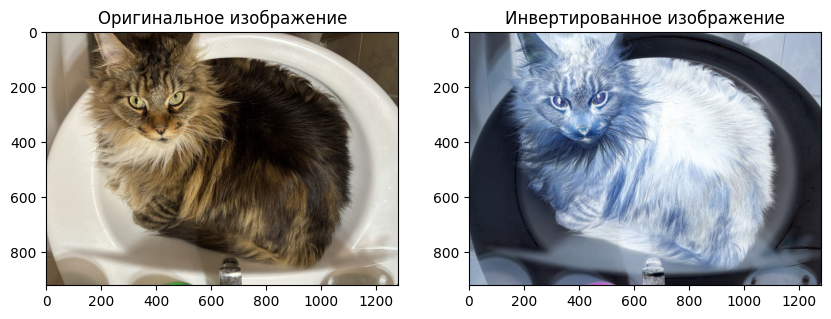

In [4]:
# Бродкастинг массива(инвертирование)
inverted_image_array = 255 - image_array

inverted_image = Image.fromarray(inverted_image_array)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Инвертированное изображение")
plt.imshow(inverted_image)
plt.show()


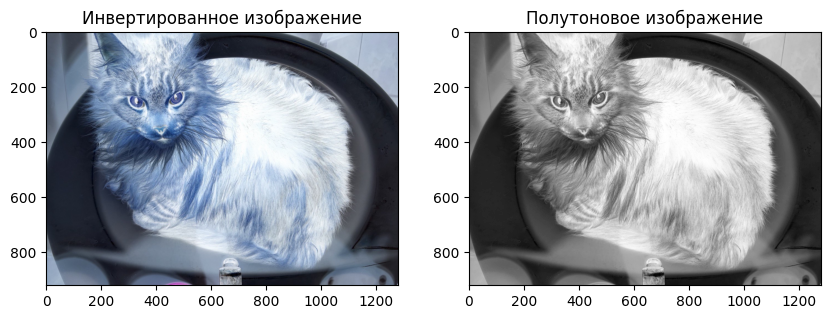

In [5]:
height, width, _ = inverted_image_array.shape
gray_image_array = np.zeros((height, width), dtype=np.uint8)

for i in range(height):
    for j in range(width):
        r, g, b = inverted_image_array[i, j].astype(np.int16)  # Преобразуем к int16, чтобы избежать переполнения
        gray_image_array[i, j] = (r + g + b) // 3

gray_image_array =  np.clip(gray_image_array, 0, 255).astype(np.uint8)

gray_image = Image.fromarray(gray_image_array, mode='L')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Инвертированное изображение")
plt.imshow(inverted_image)

plt.subplot(1, 2, 2)
plt.title("Полутоновое изображение")
plt.imshow(gray_image, cmap='gray')
plt.show()


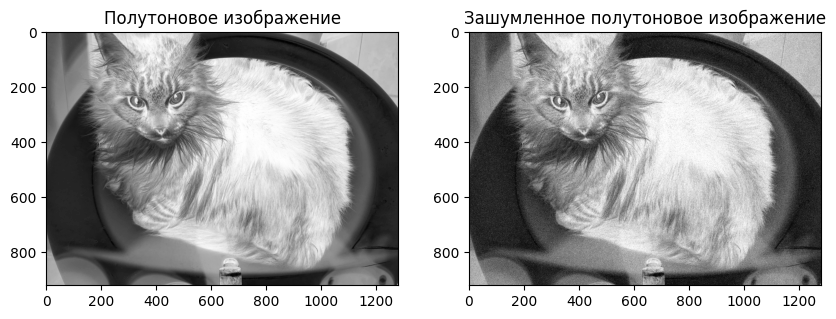

In [6]:
mean = 0
std_dev = 30

noise = np.random.normal(mean, std_dev, gray_image_array.shape).astype(np.int16)

mask = np.random.choice([0, 1], size=gray_image_array.shape, p=[0.5, 0.5])

noisy_gray_image_array = gray_image_array.astype(np.int16) + noise * mask

noisy_gray_image_array = np.clip(noisy_gray_image_array, 0, 255).astype(np.uint8)

noisy_gray_image = Image.fromarray(noisy_gray_image_array, mode='L')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Полутоновое изображение")
plt.imshow(gray_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Зашумленное полутоновое изображение")
plt.imshow(noisy_gray_image, cmap='gray')
plt.show()


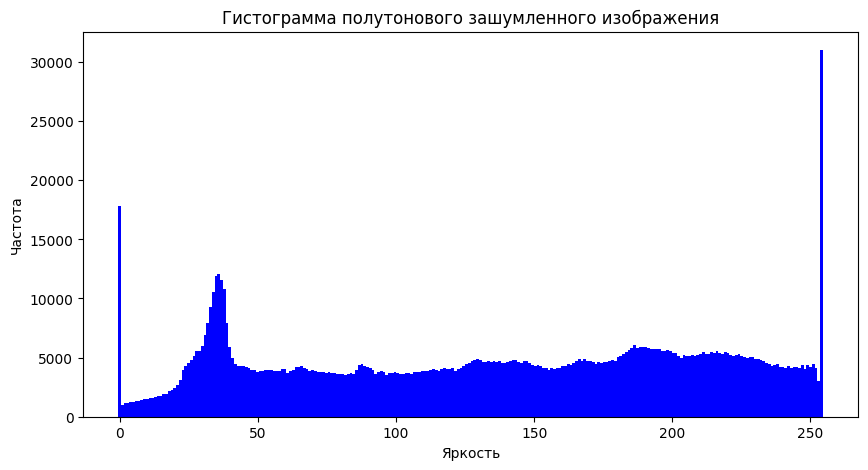

In [7]:
histogram, bins = np.histogram(noisy_gray_image_array, bins=256, range=(0, 255))

plt.figure(figsize=(10, 5))
plt.bar(bins[:-1], histogram, width=1, color='blue')
plt.title("Гистограмма полутонового зашумленного изображения")
plt.xlabel("Яркость")
plt.ylabel("Частота")
plt.show()


Результат для σ=1, размер=3:
[[ 51  63  57 ... 143 145 106]
 [ 70  88  81 ... 196 192 133]
 [ 79  96  85 ... 191 187 129]
 ...
 [124 170 170 ... 202 205 147]
 [123 168 166 ... 206 203 143]
 [ 87 119 120 ... 148 145 102]]

Результат для σ=2, размер=5:
[[ 35  46  54 ... 118 101  75]
 [ 50  66  75 ... 160 137 101]
 [ 61  79  89 ... 188 161 118]
 ...
 [105 143 170 ... 198 170 127]
 [ 89 121 143 ... 168 144 107]
 [ 65  89 105 ... 124 106  78]]

Результат для σ=4, размер=9:
[[ 29  36  43 ...  87  74  61]
 [ 37  45  53 ... 106  92  75]
 [ 44  53  63 ... 123 106  86]
 ...
 [ 78  97 113 ... 113 104  89]
 [ 67  84  98 ...  99  91  77]
 [ 54  68  79 ...  83  75  63]]



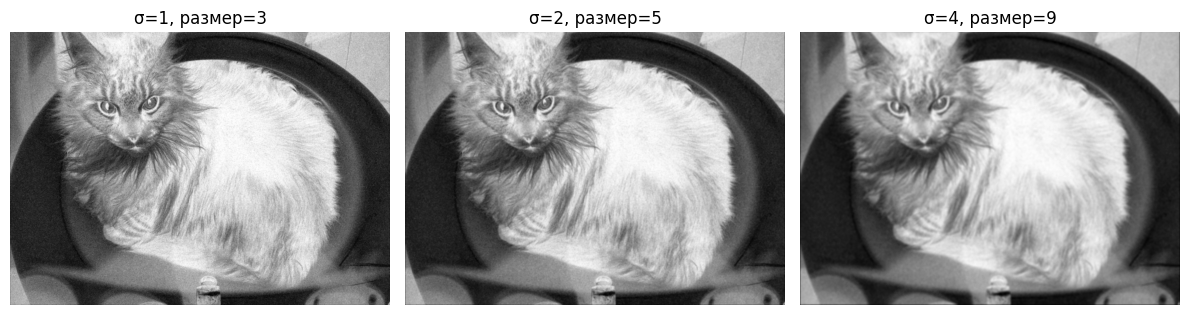

In [10]:
def gaussian_kernel(sigma, size):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / (2 * np.pi * sigma**2)  
    kernel = kernel / np.sum(kernel)  # Нормализуем ядро
    return kernel

def apply_gaussian_blur(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    padding_y, padding_x = kernel_height // 2, kernel_width // 2

    # Создаем пустой массив для результата
    blurred_image = np.zeros_like(image, dtype=np.float32)

    for i in range(image_height):
        for j in range(image_width):
            sum_value = 0.0 

            for m in range(kernel_height):
                for n in range(kernel_width):
                    # Индексы для области среза
                    x = i + m - padding_y
                    y = j + n - padding_x

                    if 0 <= x < image_height and 0 <= y < image_width:
                        sum_value += image[x, y] * kernel[m, n]

            blurred_image[i, j] = sum_value

    return np.clip(blurred_image, 0, 255).astype(np.uint8)

# Дисперсия <=> Размер ядра
kernels = [
    (1, 3), 
    (2, 5),  
    (4, 9),  
]

results = {}

for sigma, size in kernels:

    kernel = gaussian_kernel(sigma, size)

    blurred_image = apply_gaussian_blur(noisy_gray_image_array, kernel)

    results[f"σ={sigma}, размер={size}"] = blurred_image

for key, blurred_image in results.items():
    print(f"Результат для {key}:\n{blurred_image}\n")

plt.figure(figsize=(12, 8))

for idx, (key, blurred_image) in enumerate(results.items()):
    # (строки - для дисперсий, столбцы - для размеров)
    plt.subplot(1, len(results), idx + 1)
    plt.imshow(blurred_image, cmap='gray')
    plt.title(key)
    plt.axis('off')

plt.tight_layout()
plt.show()


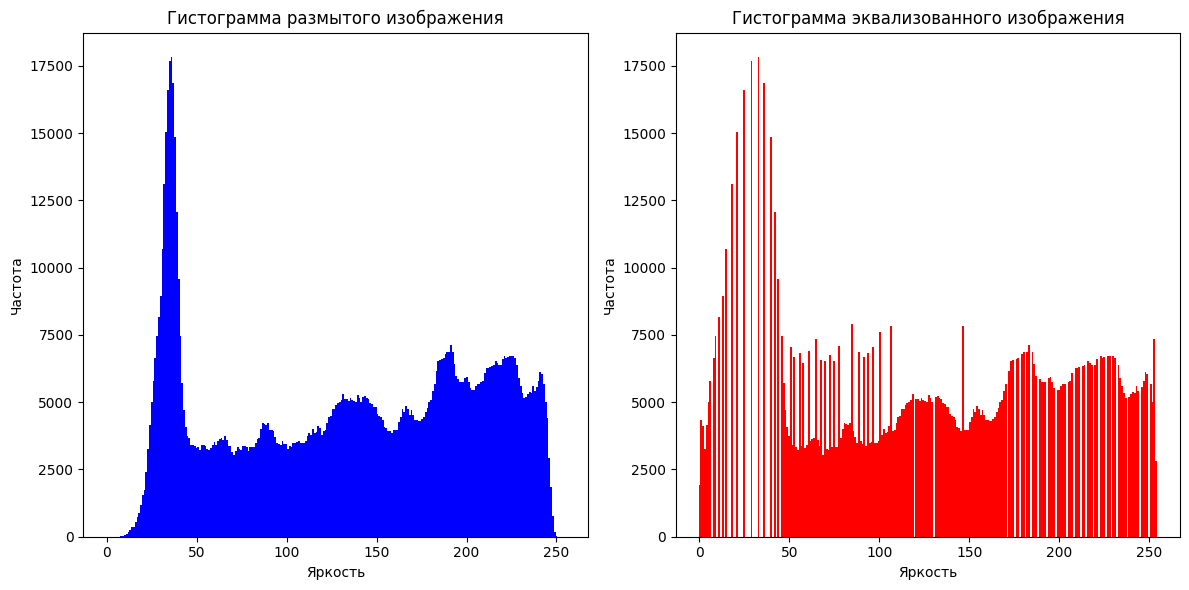

In [16]:
# Эквализация изображения
def manual_histogram_equalization(image):

    # Кол-во пикселей в конкретном интервале яркости
    histogram, _ = np.histogram(image.flatten(), bins=256, range=(0, 255))

    pixels = image.size

    cdf = histogram.cumsum()
    
    cdf_min = cdf[cdf > 0].min()
    
    equalized_image = np.zeros_like(image, dtype=np.uint8)

    for x in range(256):
        equalized_image[image == x] = round((cdf[x] - cdf_min) / (pixels - 1) * 255)

    return equalized_image

# Применение эквализации
equalized_image = manual_histogram_equalization(blurred_image)

# Построение гистограммы до эквализации
histogram, bins = np.histogram(blurred_image.flatten(), bins=256, range=(0, 255))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(bins[:-1], histogram, width=1, color='blue')
plt.title("Гистограмма размытого изображения")
plt.xlabel("Яркость")
plt.ylabel("Частота")

hist_equalized, bins_equalized = np.histogram(equalized_image.flatten(), bins=256, range=(0, 255))
plt.subplot(1, 2, 2)
plt.bar(bins_equalized[:-1], hist_equalized, width=1, color='red')
plt.title("Гистограмма эквализованного изображения")
plt.xlabel("Яркость")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()
